# Sample code - 2D Quadruped

**Description:** simple four-legged critter. Can execute a sprint from rest or generate a periodic rotatory gallop.

## Indexed symbols
Sympy lets you create multiple symbols at once in some really cool and useful ways. It's especially good when you want to build a model of varying size, like an $n$-link pendulum, for instance.

The quadruped model is symmetrical, so I'm going to use sympy's features to save myself from having to create the identical left and right sides individually. Bonus: this will also let me switch one of the sides off, so I can debug with a much smaller model and then add the second side back in when I'm sure it's good to go.

In [ ]:
# DO NOT RUN FROM THE TOP
# You can run this cell if you want to take a look at the individual components that go into the equations of motion
# but the next one has a super slow simplifying step, so avoid running that one if possible.
# The pickle containing the calculated and simplified expressions you need should be in the repo, so just start from the
# unpickling cell instead.

%reset
# DERIVE THE EOMs SYMBOLICALLY --------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters

# b = body
# f = foreleg
# h = hindleg

g = sym.symbols('g')
mb,mf1,mf2,mh1,mh2 = sym.symbols(['m_{b}','m_{f1}','m_{f2}','m_{h1}','m_{h2}']) # mass
lb,lf1,lf2,lh1,lh2 = sym.symbols(['l_{b}','l_{f1}','l_{f2}','l_{h1}','l_{h2}']) # length
Inb,Inf1,Inf2,Inh1,Inh2 = sym.symbols(['In_{b}','In_{f1}','In_{f2}','In_{h1}','In_{h2}']) # mass

# generalized coordinates

# x, y = torso COM position
# thb = body angle ccw from X
# thf1, thf2, thh1, thh2 = angles ccw from parent link (aka shoulder, elbow, hip, knee)

sides = ['R','L']
x,y,thb = sym.symbols(['x','y','\\theta_{b}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{b}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{b}']) 

thf1  = [sym.symbols('\\theta_{f1%s}'%sides[i]) for i in range(len(sides))]
thf2  = [sym.symbols('\\theta_{f2%s}'%sides[i]) for i in range(len(sides))]
thh1  = [sym.symbols('\\theta_{h1%s}'%sides[i]) for i in range(len(sides))]
thh2  = [sym.symbols('\\theta_{h2%s}'%sides[i]) for i in range(len(sides))]

dthf1  = [sym.symbols('\dot{\\theta}_{f1%s}'%sides[i]) for i in range(len(sides))]
dthf2  = [sym.symbols('\dot{\\theta}_{f2%s}'%sides[i]) for i in range(len(sides))]
dthh1  = [sym.symbols('\dot{\\theta}_{h1%s}'%sides[i]) for i in range(len(sides))]
dthh2  = [sym.symbols('\dot{\\theta}_{h2%s}'%sides[i]) for i in range(len(sides))]

ddthf1  = [sym.symbols('\ddot{\\theta}_{f1%s}'%sides[i]) for i in range(len(sides))]
ddthf2  = [sym.symbols('\ddot{\\theta}_{f2%s}'%sides[i]) for i in range(len(sides))]
ddthh1  = [sym.symbols('\ddot{\\theta}_{h1%s}'%sides[i]) for i in range(len(sides))]
ddthh2  = [sym.symbols('\ddot{\\theta}_{h2%s}'%sides[i]) for i in range(len(sides))]

q = sym.Matrix([x]+[y]+[thb]+thf1+thf2+thh1+thh2)
dq = sym.Matrix([dx]+[dy]+[dthb]+dthf1+dthf2+dthh1+dthh2)
ddq = sym.Matrix([ddx]+[ddy]+[ddthb]+ddthf1+ddthf2+ddthh1+ddthh2)

# forces
tauf1  = [sym.symbols('\\tau_{f1%s}'%sides[i]) for i in range(len(sides))]
tauf2  = [sym.symbols('\\tau_{f2%s}'%sides[i]) for i in range(len(sides))]
tauh1  = [sym.symbols('\\tau_{h1%s}'%sides[i]) for i in range(len(sides))]
tauh2  = [sym.symbols('\\tau_{h2%s}'%sides[i]) for i in range(len(sides))]

Gxf  = [sym.symbols('G_{xf%s}'%sides[i]) for i in range(len(sides))]
Gyf  = [sym.symbols('G_{yf%s}'%sides[i]) for i in range(len(sides))]
Gxh  = [sym.symbols('G_{xh%s}'%sides[i]) for i in range(len(sides))]
Gyh  = [sym.symbols('G_{yh%s}'%sides[i]) for i in range(len(sides))]

# STEP 1: position vectors, velocities and jacobians -----------------------------------------------------------------------
# ri = [x,y,theta] (world frame)

rb = sym.Matrix([[x],
                [y],
                [thb]])

rf1 = [] # link positions
rf2 = []
rh1 = []
rh2 = []

p_shoulder = [] # other useful positions
p_elbow = []
p_knee = []
p_hip = []
p_footf = []
p_footh = []

Jb = rb.jacobian(q) # jacobians
Jf1 = [] 
Jf2 = []
Jh1 = []
Jh2 = []

vb = Jb*dq # velocities
vf1 = [] 
vf2 = []
vh1 = []
vh2 = []

v_footf = [] # foot velocities
v_footh = []

for i in range(len(sides)):
    # upper leg links
    p_shoulder.append(sym.Matrix([[x + 0.5*lb*sym.cos(thb)],
                                [y + 0.5*lb*sym.sin(thb)]]))

    p_hip.append(sym.Matrix([[x - 0.5*lb*sym.cos(thb)],
                                [y - 0.5*lb*sym.sin(thb)]]))

    rf1.append(sym.Matrix([[p_shoulder[i][0] + 0.5*lf1*sym.sin(thb+thf1[i])],
                          [p_shoulder[i][1] - 0.5*lf1*sym.cos(thb+thf1[i])],
                          [thb+thf1[i]]]))
    
    rh1.append(sym.Matrix([[p_hip[i][0] + 0.5*lh1*sym.sin(thb+thh1[i])],
                          [p_hip[i][1] - 0.5*lh1*sym.cos(thb+thh1[i])],
                          [thb+thh1[i]]]))
    
    # lower leg links
    p_elbow.append(sym.Matrix([[p_shoulder[i][0] + lf1*sym.sin(thb+thf1[i])],
                                [p_shoulder[i][1] - lf1*sym.cos(thb+thf1[i])]]))

    p_knee.append(sym.Matrix([[p_hip[i][0] + lh1*sym.sin(thb+thh1[i])],
                            [p_hip[i][1] - lh1*sym.cos(thb+thh1[i])]]))
    
    rf2.append(sym.Matrix([[p_elbow[i][0] + 0.5*lf2*sym.sin(thb+thf1[i]+thf2[i])],
                          [p_elbow[i][1] - 0.5*lf2*sym.cos(thb+thf1[i]+thf2[i])],
                          [thb+thf1[i]+thf2[i]]]))
    
    rh2.append(sym.Matrix([[p_knee[i][0] + 0.5*lh2*sym.sin(thb+thh1[i]+thh2[i])],
                          [p_knee[i][1] - 0.5*lh2*sym.cos(thb+thh1[i]+thh2[i])],
                          [thb+thh1[i]+thh2[i]]]))
    
    p_footf.append(sym.Matrix([[p_elbow[i][0] + lf2*sym.sin(thb+thf1[i]+thf2[i])],
                                [p_elbow[i][1] - lf2*sym.cos(thb+thf1[i]+thf2[i])]]))

    p_footh.append(sym.Matrix([[p_knee[i][0] + lh2*sym.sin(thb+thh1[i]+thh2[i])],
                            [p_knee[i][1] - lh2*sym.cos(thb+thh1[i]+thh2[i])]]))
    
    # Jacobians
    Jf1.append(rf1[i].jacobian(q))
    Jf2.append(rf2[i].jacobian(q))
    Jh1.append(rh1[i].jacobian(q))
    Jh2.append(rh2[i].jacobian(q))
    
    # velocities
    vf1.append(Jf1[i]*dq)
    vf2.append(Jf2[i]*dq)
    vh1.append(Jh1[i]*dq)
    vh2.append(Jh2[i]*dq)
 
    # contact velocities
    v_footf.append(p_footf[i].jacobian(q)*dq)
    v_footh.append(p_footh[i].jacobian(q)*dq)
    
# STEP 2: Energy --------------------------------------------------------------------------------------------------------
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Mf1 = sym.Matrix([[mf1,mf1,Inf1]])
Mf2 = sym.Matrix([[mf2,mf2,Inf2]])
Mh1 = sym.Matrix([[mh1,mh1,Inh1]])
Mh2 = sym.Matrix([[mh2,mh2,Inh2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb)
V = mb*g*rb[1]

for i in range(len(sides)):
    T += 0.5*Mf1*sym.matrix_multiply_elementwise(vf1[i],vf1[i]) + \
    0.5*Mf2*sym.matrix_multiply_elementwise(vf2[i],vf2[i]) + \
    0.5*Mh1*sym.matrix_multiply_elementwise(vh1[i],vh1[i]) + \
    0.5*Mh2*sym.matrix_multiply_elementwise(vh2[i],vh2[i]) 
    
    V += mf1*g*rf1[i][1] + \
    mf2*g*rf2[i][1] + \
    mh1*g*rh1[i][1] + \
    mh2*g*rh2[i][1] 
    
# STEP 4: partials of T and V ----------------------------------------------------------------------------------------------
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces -----------------------------------------------------------------------------------------------

tau_f1_b = sym.Matrix([[0],[0],[-sum(tauf1)]])
tau_f1_f1 = [sym.Matrix([[0],[0],[tauf1[i]]]) for i in range(len(sides))]
tau_h1_b = sym.Matrix([[0],[0],[-sum(tauh1)]])
tau_h1_h1 = [sym.Matrix([[0],[0],[tauh1[i]]]) for i in range(len(sides))]

tau_f2_f1 = [sym.Matrix([[0],[0],[-tauf2[i]]]) for i in range(len(sides))]
tau_f2_f2 = [sym.Matrix([[0],[0],[tauf2[i]]]) for i in range(len(sides))]
tau_h2_h1 = [sym.Matrix([[0],[0],[-tauh2[i]]]) for i in range(len(sides))]
tau_h2_h2 = [sym.Matrix([[0],[0],[tauh2[i]]]) for i in range(len(sides))]

GRF_f2 = [sym.Matrix([[Gxf[i]],
                    [Gyf[i]],
                    [Gxf[i]*0.5*lf2*sym.cos(thf2[i])+Gyf[i]*0.5*lf2*sym.sin(thf2[i])]]) for i in range(len(sides))]

GRF_h2 = [sym.Matrix([[Gxh[i]],
                    [Gyh[i]],
                    [Gxh[i]*0.5*lh2*sym.cos(thh2[i])+Gyh[i]*0.5*lh2*sym.sin(thh2[i])]]) for i in range(len(sides))]

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Qj = (tau_f1_b + tau_h1_b).transpose()*Jb[:,j]
    for i in range(len(sides)):
        Qj += (tau_f1_f1[i]+tau_f2_f1[i]).transpose()*Jf1[i][:,j] +\
        (tau_h1_h1[i]+tau_h2_h1[i]).transpose()*Jh1[i][:,j] +\
        (tau_f2_f2[i]+GRF_f2[i]).transpose()*Jf2[i][:,j] +\
        (tau_h2_h2[i]+GRF_h2[i]).transpose()*Jh2[i][:,j]
    Q[j] = Qj[0]
        
#AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

In [80]:
# # TAKES FOREVER. DO NOT RERUN UNLESS YOU ABSOLUTELY HAVE TO.
# EOMs = sym.zeros(7,1)
# if len(EOM) > 7:
#     ind = [0,1,2,3,5,7,9]
# else:
#     ind = range(7)

# for j in range(7):
#     EOMs[j] = EOM[ind[j]].simplify()

# p_footf_s = sym.zeros(2,1)
# p_footh_s = sym.zeros(2,1)
# v_footf_s = sym.zeros(2,1)
# v_footh_s = sym.zeros(2,1)

# for j in range(2):
#     p_footf_s[j] = p_footf[0][j].simplify()
#     p_footh_s[j] = p_footh[0][j].simplify()
#     v_footf_s[j] = v_footf[0][j].simplify()
#     v_footh_s[j] = v_footh[0][j].simplify()

## Pickling
Use the adorably-named pickle library to *pickle* (i.e. save) Python objects for later use. I'm wary of dumping multiple objects into the same pickle file, so I just plop everthing into a single dictionary and then save that.

In [87]:
# Saving equations of motion so you don't have to generate them again
import pickle as pkl

data = {"EOM":EOMs,
       "pfootf":p_footf_s,
       "pfooth":p_footh_s,
       "vfootf":v_footf_s,
       "vfooth":v_footh_s}

outfile = open('quad_EOM','wb')
pkl.dump(data,outfile)
outfile.close()

In [11]:
# UNPICKLE (start here if you have saved EOM's to use instead)
import pickle as pkl
import sympy as sym
import numpy as np

infile = open('quad_EOM','rb')
data = pkl.load(infile)
infile.close()

EOMs = data['EOM']
p_footf_s = data['pfootf']
p_footh_s = data['pfooth']
v_footf_s = data['vfootf']
v_footh_s = data['vfooth']

g = sym.symbols('g')
mb,mf1,mf2,mh1,mh2 = sym.symbols(['m_{b}','m_{f1}','m_{f2}','m_{h1}','m_{h2}']) # mass
lb,lf1,lf2,lh1,lh2 = sym.symbols(['l_{b}','l_{f1}','l_{f2}','l_{h1}','l_{h2}']) # length
Inb,Inf1,Inf2,Inh1,Inh2 = sym.symbols(['In_{b}','In_{f1}','In_{f2}','In_{h1}','In_{h2}']) # mass

# generalized coordinates

# x, y = torso COM position
# thb = body angle ccw from X
# thf1, thf2, thh1, thh2 = angles ccw from parent link (aka shoulder, elbow, hip, knee)

sides = ['R','L']
x,y,thb = sym.symbols(['x','y','\\theta_{b}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{b}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{b}']) 

thf1  = [sym.symbols('\\theta_{f1%s}'%sides[i]) for i in range(len(sides))]
thf2  = [sym.symbols('\\theta_{f2%s}'%sides[i]) for i in range(len(sides))]
thh1  = [sym.symbols('\\theta_{h1%s}'%sides[i]) for i in range(len(sides))]
thh2  = [sym.symbols('\\theta_{h2%s}'%sides[i]) for i in range(len(sides))]

dthf1  = [sym.symbols('\dot{\\theta}_{f1%s}'%sides[i]) for i in range(len(sides))]
dthf2  = [sym.symbols('\dot{\\theta}_{f2%s}'%sides[i]) for i in range(len(sides))]
dthh1  = [sym.symbols('\dot{\\theta}_{h1%s}'%sides[i]) for i in range(len(sides))]
dthh2  = [sym.symbols('\dot{\\theta}_{h2%s}'%sides[i]) for i in range(len(sides))]

ddthf1  = [sym.symbols('\ddot{\\theta}_{f1%s}'%sides[i]) for i in range(len(sides))]
ddthf2  = [sym.symbols('\ddot{\\theta}_{f2%s}'%sides[i]) for i in range(len(sides))]
ddthh1  = [sym.symbols('\ddot{\\theta}_{h1%s}'%sides[i]) for i in range(len(sides))]
ddthh2  = [sym.symbols('\ddot{\\theta}_{h2%s}'%sides[i]) for i in range(len(sides))]

q = sym.Matrix([x]+[y]+[thb]+thf1+thf2+thh1+thh2)
dq = sym.Matrix([dx]+[dy]+[dthb]+dthf1+dthf2+dthh1+dthh2)
ddq = sym.Matrix([ddx]+[ddy]+[ddthb]+ddthf1+ddthf2+ddthh1+ddthh2)

# forces
tauf1  = [sym.symbols('\\tau_{f1%s}'%sides[i]) for i in range(len(sides))]
tauf2  = [sym.symbols('\\tau_{f2%s}'%sides[i]) for i in range(len(sides))]
tauh1  = [sym.symbols('\\tau_{h1%s}'%sides[i]) for i in range(len(sides))]
tauh2  = [sym.symbols('\\tau_{h2%s}'%sides[i]) for i in range(len(sides))]

Gxf  = [sym.symbols('G_{xf%s}'%sides[i]) for i in range(len(sides))]
Gyf  = [sym.symbols('G_{yf%s}'%sides[i]) for i in range(len(sides))]
Gxh  = [sym.symbols('G_{xh%s}'%sides[i]) for i in range(len(sides))]
Gyh  = [sym.symbols('G_{yh%s}'%sides[i]) for i in range(len(sides))]

In [12]:
# lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,
            mb,mf1,mf2,mh1,mh2,
            lb,lf1,lf2,lh1,lh2,
            Inb,Inf1,Inf2,Inh1,Inh2,
            x,y,thb]+thf1+thf2+thh1+thh2+\
            [dx,dy,dthb]+dthf1+dthf2+dthh1+dthh2+\
            [ddx,ddy,ddthb]+ddthf1+ddthf2+ddthh1+ddthh2+\
            tauf1+tauf2+tauh1+tauh2+\
            Gxf+Gyf+Gxh+Gyh

sym_list_side = [g,
            mb,mf1,mf2,mh1,mh2,
            lb,lf1,lf2,lh1,lh2,
            Inb,Inf1,Inf2,Inh1,Inh2,
            x,y,thb,thf1[0],thf2[0],thh1[0],thh2[0],
            dx,dy,dthb,dthf1[0],dthf2[0],dthh1[0],dthh2[0],
            ddx,ddy,ddthb,ddthf1[0],ddthf2[0],ddthh1[0],ddthh2[0],
            tauf1[0],tauf2[0],tauh1[0],tauh2[0],
            Gxf[0],Gyf[0],Gxh[0],Gyh[0]]

sym_list_side2 = [lb,lf1,lf2,lh1,lh2,
            x,y,thb,thf1[0],thf2[0],thh1[0],thh2[0],
            dx,dy,dthb,dthf1[0],dthf2[0],dthh1[0],dthh2[0]]

lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thf1 = sym.lambdify(sym_list_side,EOMs[3],modules = [func_map])
lambEOM_thf2 = sym.lambdify(sym_list_side,EOMs[4],modules = [func_map])
lambEOM_thh1 = sym.lambdify(sym_list_side,EOMs[5],modules = [func_map])
lambEOM_thh2 = sym.lambdify(sym_list_side,EOMs[6],modules = [func_map]) 

lamb_pfootf_y = sym.lambdify(sym_list_side2,p_footf_s[1],modules = [func_map])
lamb_pfooth_y = sym.lambdify(sym_list_side2,p_footh_s[1],modules = [func_map])
lamb_vfootf_x = sym.lambdify(sym_list_side2,v_footf_s[0],modules = [func_map])
lamb_vfooth_x = sym.lambdify(sym_list_side2,v_footh_s[0],modules = [func_map])

In [356]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 20
m.N = RangeSet(N) # number of elements

P = 1
m.P = RangeSet(1) # number of collocation points (don't worry about this for now)

sides = ['R','L']
# links
# format: (lb, ls, ln) = branch, side, number
links = [('body','T',1)]+[('legF',s,1) for s in sides]+\
[('legF',s,2) for s in sides]+\
[('legH',s,1) for s in sides]+\
[('legH',s,2) for s in sides]
m.L = Set(dimen=3, initialize = links)

# generalized coordinates
DOFs = ['x','y','thb']+['thf1%s'%s for s in sides]+\
['thf2%s'%s for s in sides]+\
['thh1%s'%s for s in sides]+\
['thh2%s'%s for s in sides]
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ls, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ls, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ls, ln): 
    l = (lb,ls,ln)
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.P, m.DOF) # position
m.dq = Var(m.N, m.P, m.DOF) # velocity
m.ddq = Var(m.N, m.P, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for p in range(1,P+1):
        m.q[n,p,'y'].setlb(0.0)

In [357]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,1,dof] == m.q[n-1,1,dof] + hm*m.h[n]*m.dq[n,1,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,1,dof] == m.dq[n-1,1,dof] + hm*m.h[n]*m.ddq[n-1,1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [358]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

signs = ['ps','ng'] # sign set for positive and negative components
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

contacts = [('legF',s,2) for s in sides]+[('legH',s,2) for s in sides] # set of contacts
m.C = Set(dimen=3, initialize = contacts) 

# variables
m.footy = Var(m.N, m.P, m.C, bounds = (0.0,None)) # foot position
m.footdx = Var(m.N, m.P, m.C, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, m.P, m.C, bounds = (0.0,None))

m.GRF = Var(m.N, m.P, m.C, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.C, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footy(m,n,p,lb,ls,ln):
    c = (lb,ls,ln)
    if lb == 'legF':
        var_list = [m.len[('body','T',1)],
                    m.len[('legF','R',1)],m.len[('legF','R',2)],m.len[('legH','R',1)],m.len[('legH','R',2)],
                    m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],
                    m.q[n,p,'thf1%s'%ls],m.q[n,p,'thf2%s'%ls],m.q[n,p,'thh1%s'%ls],m.q[n,p,'thh2%s'%ls],
                    m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],
                    m.dq[n,p,'thf1%s'%ls],m.dq[n,p,'thf2%s'%ls],m.dq[n,p,'thh1%s'%ls],m.dq[n,p,'thh2%s'%ls]]

        return m.footy[n,p,c] == lamb_pfootf_y(*var_list)
    if lb == 'legH':
        var_list = [m.len[('body','T',1)],
                    m.len[('legF','R',1)],m.len[('legF','R',2)],m.len[('legH','R',1)],m.len[('legH','R',2)],
                    m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],
                    m.q[n,p,'thf1%s'%ls],m.q[n,p,'thf2%s'%ls],m.q[n,p,'thh1%s'%ls],m.q[n,p,'thh2%s'%ls],
                    m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],
                    m.dq[n,p,'thf1%s'%ls],m.dq[n,p,'thf2%s'%ls],m.dq[n,p,'thh1%s'%ls],m.dq[n,p,'thh2%s'%ls]]
        return m.footy[n,p,c] == lamb_pfooth_y(*var_list)
    else:
        return Constraint.Skip
m.def_footy = Constraint(m.N, m.P, m.C, rule = def_footy)

def def_footdx(m,n,p,lb,ls,ln):
    c = (lb,ls,ln)
    if lb == 'legF':
        var_list = [m.len[('body','T',1)],
                    m.len[('legF','R',1)],m.len[('legF','R',2)],m.len[('legH','R',1)],m.len[('legH','R',2)],
                    m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],
                    m.q[n,p,'thf1%s'%ls],m.q[n,p,'thf2%s'%ls],m.q[n,p,'thh1%s'%ls],m.q[n,p,'thh2%s'%ls],
                    m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],
                    m.dq[n,p,'thf1%s'%ls],m.dq[n,p,'thf2%s'%ls],m.dq[n,p,'thh1%s'%ls],m.dq[n,p,'thh2%s'%ls]]
        return m.footdx[n,p,c,'ps']-m.footdx[n,p,c,'ng'] == lamb_vfootf_x(*var_list)
    if lb == 'legH':
        var_list = [m.len[('body','T',1)],
                    m.len[('legF','R',1)],m.len[('legF','R',2)],m.len[('legH','R',1)],m.len[('legH','R',2)],
                    m.q[n,p,'x'],m.q[n,p,'y'],m.q[n,p,'thb'],
                    m.q[n,p,'thf1%s'%ls],m.q[n,p,'thf2%s'%ls],m.q[n,p,'thh1%s'%ls],m.q[n,p,'thh2%s'%ls],
                    m.dq[n,p,'x'],m.dq[n,p,'y'],m.dq[n,p,'thb'],
                    m.dq[n,p,'thf1%s'%ls],m.dq[n,p,'thf2%s'%ls],m.dq[n,p,'thh1%s'%ls],m.dq[n,p,'thh2%s'%ls]]
        return m.footdx[n,p,c,'ps']-m.footdx[n,p,c,'ng'] == lamb_vfooth_x(*var_list)
    else:
        return Constraint.Skip
m.def_footdx = Constraint(m.N, m.P, m.C, rule = def_footdx)

def def_friction_cone(m,n,p,lb,ls,ln):
    c = (lb,ls,ln)
    return m.friction_cone[n,p,c] == m.mu*m.GRF[n,p,c,'Y','ps'] - (m.GRF[n,p,c,'X','ps'] + m.GRF[n,p,c,'X','ng'])
m.def_friction_cone = Constraint(m.N, m.P, m.C, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n,lb,ls,ln):
    c = (lb,ls,ln)
    if n < N:
        return m.ground_penalty[n,c,'contact'] == m.footy[n+1,1,c]*m.GRF[n,1,c,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, m.C, rule = ground_contact)

# friction
def ground_friction(m,n,lb,ls,ln):
    c = (lb,ls,ln)
    if n < N:
        return m.ground_penalty[n,c,'friction'] == (m.footdx[n+1,1,c,'ps']+m.footdx[n+1,1,c,'ng'])*m.friction_cone[n,1,c]
    else:
        return Constraint.Skip
m.ground_friction = Constraint(m.N, m.C, rule = ground_friction)

# slipping
def ground_slip_ps(m,n,lb,ls,ln):
    c = (lb,ls,ln)
    if n < N:
        return m.ground_penalty[n,c,'slip_ps'] == m.footdx[n+1,1,c,'ps']*m.GRF[n,1,c,'X','ps']
    else:
        return Constraint.Skip
m.ground_slip_ps = Constraint(m.N, m.C, rule = ground_slip_ps)

def ground_slip_ng(m,n,lb,ls,ln):
    c = (lb,ls,ln)
    if n < N:
        return m.ground_penalty[n,c,'slip_ng'] == m.footdx[n+1,1,c,'ng']*m.GRF[n,1,c,'X','ng']
    else:
        return Constraint.Skip
m.ground_slip_ng = Constraint(m.N, m.C, rule = ground_slip_ng)

# bound contact forces at last node
for p in range(1,P+1):
    for c in contacts:
        for dof in WDOFs:
            for sgn in signs:
                m.GRF[N,p,c,dof,sgn].value = 0
                m.GRF[N,p,c,dof,sgn].fixed = True

In [359]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['thf1%s'%s for s in sides]+['thf2%s'%s for s in sides]+\
['thh1%s'%s for s in sides]+['thh2%s'%s for s in sides] # set of joints
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# bound the joints
for n in range(1,N+1):
    for p in range(1,P+1):
        m.q[n,p,'thb'].setlb(-np.pi)
        m.q[n,p,'thb'].setub(np.pi) 
        
        [m.q[n,p,'thf1%s'%s].setlb(-np.pi/2) for s in sides]
        [m.q[n,p,'thf1%s'%s].setub(np.pi/2) for s in sides]
        [m.q[n,p,'thh1%s'%s].setlb(-np.pi/2) for s in sides]
        [m.q[n,p,'thh1%s'%s].setub(np.pi/2) for s in sides]
        
        [m.q[n,p,'thf2%s'%s].setlb(0.0) for s in sides]
        [m.q[n,p,'thf2%s'%s].setub(0.75*np.pi) for s in sides]
        [m.q[n,p,'thh2%s'%s].setlb(-0.75*np.pi) for s in sides]
        [m.q[n,p,'thh2%s'%s].setub(0.0) for s in sides]
        
# variables
m.tau_a = Var(m.N, m.J, bounds = (-2,2)) # actuator torque
m.tau_r = Var(m.N, m.P, m.J, m.sgn, bounds = (0.0,None)) # rebound torque

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# complementarity
def joint_limits(m,n,j,jc):
    if n < N:
        if jc == 'up':
            return m.joint_penalty[n,j,jc] == (m.q[2,1,j].ub - m.q[n+1,1,j])*m.tau_r[n,1,j,'ng']
        else:
            return m.joint_penalty[n,j,jc] == (m.q[n+1,1,j] - m.q[2,1,j].lb)*m.tau_r[n,1,j,'ps']
    else:
        return Constraint.Skip
m.joint_limits = Constraint(m.N, m.J, m.joint_constraints, rule = joint_limits)

# bound contact forces at last node
for p in range(1,P+1):
    for j in joints:
        for sgn in signs:
            m.tau_r[N,p,j,sgn].value = 0
            m.tau_r[N,p,j,sgn].fixed = True

In [360]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n,p):
    var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%s] for s in sides]+\
            [m.q[n,p,'thf2%s'%s] for s in sides]+\
            [m.q[n,p,'thh1%s'%s] for s in sides]+\
            [m.q[n,p,'thh2%s'%s] for s in sides]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%s] for s in sides]+\
            [m.dq[n,p,'thf2%s'%s] for s in sides]+\
            [m.dq[n,p,'thh1%s'%s] for s in sides]+\
            [m.dq[n,p,'thh2%s'%s] for s in sides]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%s] for s in sides]+\
            [m.ddq[n,p,'thf2%s'%s] for s in sides]+\
            [m.ddq[n,p,'thh1%s'%s] for s in sides]+\
            [m.ddq[n,p,'thh2%s'%s] for s in sides]+\
            [S*m.tau_a[n,'thf1%s'%s]+S*m.tau_r[n,p,'thf1%s'%s,'ps']-S*m.tau_r[n,p,'thf1%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thf2%s'%s]+S*m.tau_r[n,p,'thf2%s'%s,'ps']-S*m.tau_r[n,p,'thf2%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thh1%s'%s]+S*m.tau_r[n,p,'thh1%s'%s,'ps']-S*m.tau_r[n,p,'thh1%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thh2%s'%s]+S*m.tau_r[n,p,'thh2%s'%s,'ps']-S*m.tau_r[n,p,'thh2%s'%s,'ng'] for s in sides]+\
            [S*m.GRF[n,p,('legF',s,2),'X','ps']-S*m.GRF[n,p,('legF',s,2),'X','ng'] for s in sides]+\
            [S*m.GRF[n,p,('legF',s,2),'Y','ps'] for s in sides]+\
            [S*m.GRF[n,p,('legH',s,2),'X','ps']-S*m.GRF[n,p,('legH',s,2),'X','ng'] for s in sides]+\
            [S*m.GRF[n,p,('legH',s,2),'Y','ps'] for s in sides] 
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.P, rule = EOM_x)

def EOM_y(m,n,p):
    var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%s] for s in sides]+\
            [m.q[n,p,'thf2%s'%s] for s in sides]+\
            [m.q[n,p,'thh1%s'%s] for s in sides]+\
            [m.q[n,p,'thh2%s'%s] for s in sides]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%s] for s in sides]+\
            [m.dq[n,p,'thf2%s'%s] for s in sides]+\
            [m.dq[n,p,'thh1%s'%s] for s in sides]+\
            [m.dq[n,p,'thh2%s'%s] for s in sides]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%s] for s in sides]+\
            [m.ddq[n,p,'thf2%s'%s] for s in sides]+\
            [m.ddq[n,p,'thh1%s'%s] for s in sides]+\
            [m.ddq[n,p,'thh2%s'%s] for s in sides]+\
            [S*m.tau_a[n,'thf1%s'%s]+S*m.tau_r[n,p,'thf1%s'%s,'ps']-S*m.tau_r[n,p,'thf1%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thf2%s'%s]+S*m.tau_r[n,p,'thf2%s'%s,'ps']-S*m.tau_r[n,p,'thf2%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thh1%s'%s]+S*m.tau_r[n,p,'thh1%s'%s,'ps']-S*m.tau_r[n,p,'thh1%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thh2%s'%s]+S*m.tau_r[n,p,'thh2%s'%s,'ps']-S*m.tau_r[n,p,'thh2%s'%s,'ng'] for s in sides]+\
            [S*m.GRF[n,p,('legF',s,2),'X','ps']-S*m.GRF[n,p,('legF',s,2),'X','ng'] for s in sides]+\
            [S*m.GRF[n,p,('legF',s,2),'Y','ps'] for s in sides]+\
            [S*m.GRF[n,p,('legH',s,2),'X','ps']-S*m.GRF[n,p,('legH',s,2),'X','ng'] for s in sides]+\
            [S*m.GRF[n,p,('legH',s,2),'Y','ps'] for s in sides]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.P, rule = EOM_y)

def EOM_thb(m,n,p):
    var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%s] for s in sides]+\
            [m.q[n,p,'thf2%s'%s] for s in sides]+\
            [m.q[n,p,'thh1%s'%s] for s in sides]+\
            [m.q[n,p,'thh2%s'%s] for s in sides]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%s] for s in sides]+\
            [m.dq[n,p,'thf2%s'%s] for s in sides]+\
            [m.dq[n,p,'thh1%s'%s] for s in sides]+\
            [m.dq[n,p,'thh2%s'%s] for s in sides]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%s] for s in sides]+\
            [m.ddq[n,p,'thf2%s'%s] for s in sides]+\
            [m.ddq[n,p,'thh1%s'%s] for s in sides]+\
            [m.ddq[n,p,'thh2%s'%s] for s in sides]+\
            [S*m.tau_a[n,'thf1%s'%s]+S*m.tau_r[n,p,'thf1%s'%s,'ps']-S*m.tau_r[n,p,'thf1%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thf2%s'%s]+S*m.tau_r[n,p,'thf2%s'%s,'ps']-S*m.tau_r[n,p,'thf2%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thh1%s'%s]+S*m.tau_r[n,p,'thh1%s'%s,'ps']-S*m.tau_r[n,p,'thh1%s'%s,'ng'] for s in sides]+\
            [S*m.tau_a[n,'thh2%s'%s]+S*m.tau_r[n,p,'thh2%s'%s,'ps']-S*m.tau_r[n,p,'thh2%s'%s,'ng'] for s in sides]+\
            [S*m.GRF[n,p,('legF',s,2),'X','ps']-S*m.GRF[n,p,('legF',s,2),'X','ng'] for s in sides]+\
            [S*m.GRF[n,p,('legF',s,2),'Y','ps'] for s in sides]+\
            [S*m.GRF[n,p,('legH',s,2),'X','ps']-S*m.GRF[n,p,('legH',s,2),'X','ng'] for s in sides]+\
            [S*m.GRF[n,p,('legH',s,2),'Y','ps'] for s in sides]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, m.P, rule = EOM_thb)

def EOM_thf1(m,n,p,lb,ls,ln):
    if lb == 'legF' and ln == 1:
        var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%ls]]+\
            [m.q[n,p,'thf2%s'%ls]]+\
            [m.q[n,p,'thh1%s'%ls]]+\
            [m.q[n,p,'thh2%s'%ls]]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%ls]]+\
            [m.dq[n,p,'thf2%s'%ls]]+\
            [m.dq[n,p,'thh1%s'%ls]]+\
            [m.dq[n,p,'thh2%s'%ls]]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%ls]]+\
            [m.ddq[n,p,'thf2%s'%ls]]+\
            [m.ddq[n,p,'thh1%s'%ls]]+\
            [m.ddq[n,p,'thh2%s'%ls]]+\
            [S*m.tau_a[n,'thf1%s'%ls]+S*m.tau_r[n,p,'thf1%s'%ls,'ps']-S*m.tau_r[n,p,'thf1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thf2%s'%ls]+S*m.tau_r[n,p,'thf2%s'%ls,'ps']-S*m.tau_r[n,p,'thf2%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh1%s'%ls]+S*m.tau_r[n,p,'thh1%s'%ls,'ps']-S*m.tau_r[n,p,'thh1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh2%s'%ls]+S*m.tau_r[n,p,'thh2%s'%ls,'ps']-S*m.tau_r[n,p,'thh2%s'%ls,'ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'X','ps']-S*m.GRF[n,p,('legF',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'Y','ps']]+\
            [S*m.GRF[n,p,('legH',ls,2),'X','ps']-S*m.GRF[n,p,('legH',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legH',ls,2),'Y','ps']]
        return lambEOM_thf1(*var_list) == 0
    else:
        return Constraint.Skip
m.EOM_thf1 = Constraint(m.N, m.P, m.L, rule = EOM_thf1)

def EOM_thh1(m,n,p,lb,ls,ln):
    if lb == 'legH' and ln == 1:
        var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%ls]]+\
            [m.q[n,p,'thf2%s'%ls]]+\
            [m.q[n,p,'thh1%s'%ls]]+\
            [m.q[n,p,'thh2%s'%ls]]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%ls]]+\
            [m.dq[n,p,'thf2%s'%ls]]+\
            [m.dq[n,p,'thh1%s'%ls]]+\
            [m.dq[n,p,'thh2%s'%ls]]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%ls]]+\
            [m.ddq[n,p,'thf2%s'%ls]]+\
            [m.ddq[n,p,'thh1%s'%ls]]+\
            [m.ddq[n,p,'thh2%s'%ls]]+\
            [S*m.tau_a[n,'thf1%s'%ls]+S*m.tau_r[n,p,'thf1%s'%ls,'ps']-S*m.tau_r[n,p,'thf1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thf2%s'%ls]+S*m.tau_r[n,p,'thf2%s'%ls,'ps']-S*m.tau_r[n,p,'thf2%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh1%s'%ls]+S*m.tau_r[n,p,'thh1%s'%ls,'ps']-S*m.tau_r[n,p,'thh1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh2%s'%ls]+S*m.tau_r[n,p,'thh2%s'%ls,'ps']-S*m.tau_r[n,p,'thh2%s'%ls,'ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'X','ps']-S*m.GRF[n,p,('legF',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'Y','ps']]+\
            [S*m.GRF[n,p,('legH',ls,2),'X','ps']-S*m.GRF[n,p,('legH',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legH',ls,2),'Y','ps']]
        return lambEOM_thh1(*var_list) == 0
    else:
        return Constraint.Skip
m.EOM_thh1 = Constraint(m.N, m.P, m.L, rule = EOM_thh1)

def EOM_thf2(m,n,p,lb,ls,ln):
    if lb == 'legF' and ln == 2:
        var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%ls]]+\
            [m.q[n,p,'thf2%s'%ls]]+\
            [m.q[n,p,'thh1%s'%ls]]+\
            [m.q[n,p,'thh2%s'%ls]]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%ls]]+\
            [m.dq[n,p,'thf2%s'%ls]]+\
            [m.dq[n,p,'thh1%s'%ls]]+\
            [m.dq[n,p,'thh2%s'%ls]]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%ls]]+\
            [m.ddq[n,p,'thf2%s'%ls]]+\
            [m.ddq[n,p,'thh1%s'%ls]]+\
            [m.ddq[n,p,'thh2%s'%ls]]+\
            [S*m.tau_a[n,'thf1%s'%ls]+S*m.tau_r[n,p,'thf1%s'%ls,'ps']-S*m.tau_r[n,p,'thf1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thf2%s'%ls]+S*m.tau_r[n,p,'thf2%s'%ls,'ps']-S*m.tau_r[n,p,'thf2%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh1%s'%ls]+S*m.tau_r[n,p,'thh1%s'%ls,'ps']-S*m.tau_r[n,p,'thh1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh2%s'%ls]+S*m.tau_r[n,p,'thh2%s'%ls,'ps']-S*m.tau_r[n,p,'thh2%s'%ls,'ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'X','ps']-S*m.GRF[n,p,('legF',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'Y','ps']]+\
            [S*m.GRF[n,p,('legH',ls,2),'X','ps']-S*m.GRF[n,p,('legH',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legH',ls,2),'Y','ps']]
        return lambEOM_thf2(*var_list) == 0
    else:
        return Constraint.Skip
m.EOM_thf2 = Constraint(m.N, m.P, m.L, rule = EOM_thf2)

def EOM_thh2(m,n,p,lb,ls,ln):
    if lb == 'legH' and ln == 2:
        var_list = [m.g]+\
            [m.m[('body','T',1)]]+\
            [m.m[('legF','R',1)]]+\
            [m.m[('legF','R',2)]]+\
            [m.m[('legH','R',1)]]+\
            [m.m[('legH','R',2)]]+\
            [m.len[('body','T',1)]]+\
            [m.len[('legF','R',1)]]+\
            [m.len[('legF','R',2)]]+\
            [m.len[('legH','R',1)]]+\
            [m.len[('legH','R',2)]]+\
            [m.In[('body','T',1)]]+\
            [m.In[('legF','R',1)]]+\
            [m.In[('legF','R',2)]]+\
            [m.In[('legH','R',1)]]+\
            [m.In[('legH','R',2)]]+\
            [m.q[n,p,'x']]+\
            [m.q[n,p,'y']]+\
            [m.q[n,p,'thb']]+\
            [m.q[n,p,'thf1%s'%ls]]+\
            [m.q[n,p,'thf2%s'%ls]]+\
            [m.q[n,p,'thh1%s'%ls]]+\
            [m.q[n,p,'thh2%s'%ls]]+\
            [m.dq[n,p,'x']]+\
            [m.dq[n,p,'y']]+\
            [m.dq[n,p,'thb']]+\
            [m.dq[n,p,'thf1%s'%ls]]+\
            [m.dq[n,p,'thf2%s'%ls]]+\
            [m.dq[n,p,'thh1%s'%ls]]+\
            [m.dq[n,p,'thh2%s'%ls]]+\
            [m.ddq[n,p,'x']]+\
            [m.ddq[n,p,'y']]+\
            [m.ddq[n,p,'thb']]+\
            [m.ddq[n,p,'thf1%s'%ls]]+\
            [m.ddq[n,p,'thf2%s'%ls]]+\
            [m.ddq[n,p,'thh1%s'%ls]]+\
            [m.ddq[n,p,'thh2%s'%ls]]+\
            [S*m.tau_a[n,'thf1%s'%ls]+S*m.tau_r[n,p,'thf1%s'%ls,'ps']-S*m.tau_r[n,p,'thf1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thf2%s'%ls]+S*m.tau_r[n,p,'thf2%s'%ls,'ps']-S*m.tau_r[n,p,'thf2%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh1%s'%ls]+S*m.tau_r[n,p,'thh1%s'%ls,'ps']-S*m.tau_r[n,p,'thh1%s'%ls,'ng']]+\
            [S*m.tau_a[n,'thh2%s'%ls]+S*m.tau_r[n,p,'thh2%s'%ls,'ps']-S*m.tau_r[n,p,'thh2%s'%ls,'ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'X','ps']-S*m.GRF[n,p,('legF',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legF',ls,2),'Y','ps']]+\
            [S*m.GRF[n,p,('legH',ls,2),'X','ps']-S*m.GRF[n,p,('legH',ls,2),'X','ng']]+\
            [S*m.GRF[n,p,('legH',ls,2),'Y','ps']]
        return lambEOM_thh2(*var_list) == 0
    else:
        return Constraint.Skip
m.EOM_thh2 = Constraint(m.N, m.P, m.L, rule = EOM_thh2)

In [361]:
# INITIALIZATION
guide = np.linspace(0.0,5.0,N)
for n in range(1,N+1):
    m.q[n,1,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
    m.q[n,1,'y'].value  = np.random.uniform(0.5,1.1)
    m.q[n,1,'thb'].value  = np.random.uniform(-np.pi/8,np.pi/8)
    for j in joints:
        m.q[n,1,j].value = np.random.uniform(m.q[n,1,j].lb,m.q[n,1,j].ub)
    
    for c in contacts:
        m.GRF[n,1,c,'Y','ps'].value = np.random.uniform(0.0,1)
        m.GRF[n,1,c,'X','ps'].value = m.mu.value*m.GRF[n,1,c,'Y','ps'].value

In [362]:
# # HIGH DROP TEST
# # initial condition

# for dof in DOFs:
#     m.q[1,1,dof].value = 0.0
#     m.q[1,1,dof].fixed = True
#     m.dq[1,1,dof].value = 0.0
#     m.dq[1,1,dof].fixed = True
    
# for n in range(1,N):
#     for j in joints:
#         m.tau_a[n,j].value = 0.0
#         m.tau_a[n,j].fixed = True

# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'y'].value = 5.0

# # for j in joints:
# #     for s in signs:
# #         m.tau_r[1,1,j,sgn].value = 0.0
# #         m.tau_r[1,1,j,sgn].fixed = True

# # for n in range(1,N+1):
# #     for c in contacts:
# #         for dof in WDOFs:
# #             for s in signs:
# #                 m.GRF[n,1,c,dof,s].value = 0.0
# #                 m.GRF[n,1,c,dof,s].fixed = True
                
# #     for j in joints:
# #         for s in signs:
# #                 m.tau_r[n,1,j,s].value = 0.0
# #                 m.tau_r[n,1,j,s].fixed = True

In [363]:
# LOW DROP TEST
# initial condition

# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True

# for j in joints:
#     m.q[1,1,j].value = 0.0
#     m.q[1,1,j].fixed = True
    
# for c in contacts:
#     m.footy[1,1,c].value = 0.1
#     m.footy[1,1,c].fixed = True
    
# for dof in DOFs:
#     m.dq[1,1,dof].value = 0.0
#     m.dq[1,1,dof].fixed = True
    
# for n in range(1,N):
#     for j in joints:
#         m.tau_a[n,j].value = 0.0
#         m.tau_a[n,j].fixed = True
        
# for j in joints:
#     for s in signs:
#             m.tau_r[n,1,j,s].value = 0.0
#             m.tau_r[n,1,j,s].fixed = True


In [364]:
# STANDING TEST
# initial condition

# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True

# for j in joints:
#     m.q[1,1,j].value = 0.0
#     m.q[1,1,j].fixed = True
    
# for c in contacts:
#     m.footy[1,1,c].value = 0.0
#     m.footy[1,1,c].fixed = True

# for dof in DOFs:
#     m.dq[1,1,dof].value = 0.0
#     m.dq[1,1,dof].fixed = True
    
# for n in range(1,N):
#     for j in joints:
#         m.tau_a[n,j].value = 0.0
#         m.tau_a[n,j].fixed = True
        
# for j in joints:
#     for s in signs:
#             m.tau_r[n,1,j,s].value = 0.0
#             m.tau_r[n,1,j,s].fixed = True


In [365]:
# # HOP TEST
# # initial condition

# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True

# for j in joints:
#     m.q[1,1,j].value = 0.0
#     m.q[1,1,j].fixed = True
    
# for c in contacts:
#     m.footy[1,1,c].value = 0.0
#     m.footy[1,1,c].fixed = True

# for dof in DOFs:
#     m.dq[1,1,dof].value = 0.0
#     m.dq[1,1,dof].fixed = True
    
# # final condition
# m.q[N,1,'y'].setlb(1.1)

In [366]:
# # SPRINT TEST
# # initial condition
# # suggested N = 80

# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True

# for j in joints:
#     m.q[1,1,j].value = 0.0
#     m.q[1,1,j].fixed = True
    
# for c in contacts:
#     m.footy[1,1,c].value = 0.0
#     m.footy[1,1,c].fixed = True

# for dof in DOFs:
#     m.dq[1,1,dof].value = 0.0
#     m.dq[1,1,dof].fixed = True
    
# # final condition
# m.q[N,1,'x'].setlb(5.0)

## Generating steady-state gaits
Our lab is interested in legged manoeuvrability (acceleration, deceleration, turning, etc.) but to study these motions, we first need a constant speed gait to work from: you can't generate the transients without the context of the steady state. 

Trajectory optimization lets us create ideal, perfectly periodic gaits: you just have to set up a *bookend* constraint that makes the final state (position and velocity) the same as the initial state. A minimum average speed is set by forcing it to travel a specific distance in a given time.

Unless you're very lucky, these constraints alone are unlikely to produce a motion matching anything you'd see in nature, so you may need to specify a few more things if you want to get a particular gait out. Some tricks to try:
* Specify the apex of the flight phase as your initial point: $\ddot{y} = -mg$ and $\dot{y} = 0$. I find this is more likely to produce a natural-looking gait than starting it from a stance phase since to satisfy the bookend condition, it will need to fall and then push off the ground.
* To force a specific foot to hit the ground: constrain the sum of the normal force $G_y[n]$ to be $\geq BW$ over the desired node range. (Trying to manipulate the foot contact sequence using the foot height doesn't guarantee a weight-bearing contact, so use the GRF instead).
* To prevent a foot from hitting the ground or force a flight phase, fix the GRF to zero in the desired node range.

Note: forcing a contact order is best done over ranges of nodes, not by e.g. setting the foot height or GRF at any specific node to a value. You want to allow it a certain amount of time flexibility. I also try to avoid specifying positions and velocities as far as possible, but you'll see that I do fix the body pose at the flight phase apexes to make sure I get the extended or collected postures I want.

In [367]:
# STEADY-STATE GAIT GENERATION - ROTATORY GALLOP
# suggested N = 20

# must start and end in the same state
def ss_p(m,dof): 
    if dof == 'x':
        return Constraint.Skip
    else:
        return m.q[1,1,dof] == m.q[N,1,dof]
m.ss_p = Constraint(m.DOF, rule = ss_p)

def ss_v(m,dof): 
    return m.dq[1,1,dof] == m.dq[N,1,dof]
m.ss_v = Constraint(m.DOF, rule = ss_v)

# all feet must touch down at least once
def touchdown(m,cb,cs,cn):
    c = (cb,cs,cn)
    GRF_sum = 0
    for n in range(1,N+1):
        GRF_sum += m.GRF[n,1,c,'Y','ps']
    return GRF_sum >= 1
m.touchdown = Constraint(m.C, rule = touchdown)

# initial condition - extended flight phase
m.ddq[1,1,'y'].value = -9.81
m.dq[1,1,'y'].value = 0.0
m.ddq[1,1,'y'].fixed = True
m.dq[1,1,'y'].fixed = True

m.q[1,1,'x'].value = 0.0
m.q[1,1,'thb'].value = np.pi/32
m.q[1,1,'thf1R'].value = np.pi/4
m.q[1,1,'thf2R'].value = 0.0
m.q[1,1,'thf1L'].value = np.pi/4
m.q[1,1,'thf2L'].value = np.pi/6
m.q[1,1,'thh1R'].value = -np.pi/3
m.q[1,1,'thh2R'].value = -np.pi/6
m.q[1,1,'thh1L'].value = -np.pi/3
m.q[1,1,'thh2L'].value = -np.pi/6

m.q[1,1,'x'].fixed = True
m.q[1,1,'thb'].fixed = True
m.q[1,1,'thf1R'].fixed = True
m.q[1,1,'thf2R'].fixed = True
m.q[1,1,'thf1L'].fixed = True
m.q[1,1,'thf2L'].fixed = True
m.q[1,1,'thh1R'].fixed = True
m.q[1,1,'thh2R'].fixed = True
m.q[1,1,'thh1L'].fixed = True
m.q[1,1,'thh2L'].fixed = True

# only allow forefoot contact for first half
for n in range(1,N/2):
    for c in [('legH','R',2),('legH','L',2)]:
        for dof in WDOFs:
            for s in signs:
                m.GRF[n,1,c,dof,s].value = 0.0
                m.GRF[n,1,c,dof,s].fixed = True

# middle condition - collected suspension
m.ddq[0.5*N,1,'y'].value = -9.81
m.dq[0.5*N,1,'y'].value = 0.0
m.ddq[0.5*N,1,'y'].fixed = True
m.dq[0.5*N,1,'y'].fixed = True

m.q[0.5*N,1,'thf1R'].value = -np.pi/3
m.q[0.5*N,1,'thf2R'].value = np.pi/2
m.q[0.5*N,1,'thf1L'].value = -np.pi/3
m.q[0.5*N,1,'thf2L'].value = 0.0
m.q[0.5*N,1,'thh1R'].value = np.pi/2
m.q[0.5*N,1,'thh2R'].value = -np.pi/3
m.q[0.5*N,1,'thh1L'].value = np.pi/4
m.q[0.5*N,1,'thh2L'].value = 0.0

m.q[0.5*N,1,'thf1R'].fixed = True
m.q[0.5*N,1,'thf2R'].fixed = True
m.q[0.5*N,1,'thf1L'].fixed = True
m.q[0.5*N,1,'thf2L'].fixed = True
m.q[0.5*N,1,'thh1R'].fixed = True
m.q[0.5*N,1,'thh2R'].fixed = True
m.q[0.5*N,1,'thh1L'].fixed = True
m.q[0.5*N,1,'thh2L'].fixed = True

# only allow hindfoot contact for second half
for n in range(N/2,N+1):
    for c in [('legF','R',2),('legF','L',2)]:
        for dof in WDOFs:
            for s in signs:
                m.GRF[n,1,c,dof,s].value = 0.0
                m.GRF[n,1,c,dof,s].fixed = True

# final condition
m.q[N,1,'x'].setlb(3.0)



## Iterative Solving
The effect that a particular objective will have on the solving process is a bit of a crapshoot. Some seem to guide the solver, while others lead it into tricky places where solutions are a long time coming and *restoration failed* is always right around the corner.

One thing that seems to help with difficult cost functions is solving the problem in stages: first, you solve it with only the feasibility condition (i.e. minimizing the penalty) and then you solve it again with the objective you actually care about. It's basically a fancy initialization routine: instead of trying to find the optimal solution from some bad place where the random guess starts things, you're finding a guess that at least completes the motion within the rules of physics even if it isn't the fastest/ shortest distance/ least torque-intensive/ least whatever version of the motion.

## An important warning
There are tons of tricks like this out there that can potentially help your model solve more quickly and consistently, but you must keep the Golden Rule in mind: 

**Tricks can make a working model faster, but they can't make a broken model work.**

If the most basic, stripped-back, MTV-Unplugged-Acoustic-set version of your model doesn't solve, piling a bunch of stuff on top of it will accomplish nothing beyond making it harder to debug.

In [368]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def MinTime(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    for n in range(1,N+1):
        for c in contacts:
            for gc in ground_constraints:
                penalty_sum += m.ground_penalty[n,c,gc]
        for j in joints:
            for jc in joint_constraints:
                penalty_sum += m.joint_penalty[n,j,jc]
    return T + 1000*penalty_sum
m.MinTime = Objective(rule = MinTime)

# minimum effort

def MinTorque(m):
    torque_sum = 0
    for n in range(1,N+1):
        for j in joints:
            torque_sum += m.tau_a[n,j]**2
    
    penalty_sum = 0
    for n in range(1,N+1):
        for c in contacts:
            for gc in ground_constraints:
                penalty_sum += m.ground_penalty[n,c,gc]
        for j in joints:
            for jc in joint_constraints:
                penalty_sum += m.joint_penalty[n,j,jc]
    return torque_sum + 1000*penalty_sum
m.MinTorque = Objective(rule = MinTorque)

# feasibility

def MinPenalty(m):
    penalty_sum = 0
    for n in range(1,N+1):
        for c in contacts:
            for gc in ground_constraints:
                penalty_sum += m.ground_penalty[n,c,gc]
        for j in joints:
            for jc in joint_constraints:
                penalty_sum += m.joint_penalty[n,j,jc]
    return penalty_sum
m.MinPenalty = Objective(rule = MinPenalty)

In [ ]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Stacey/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
#opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 3600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

# solve for feasbility by deactivating other cost functions
m.MinTime.deactivate() 
m.MinTorque.deactivate()
results1 = opt.solve(m, tee = True) 

# re-activate the minimum torque function and then solve again 
# don't forget to deactivate the feasibility objective
m.MinPenalty.deactivate()
m.MinTorque.activate()
results2 = opt.solve(m, tee = True) 

In [ ]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.


penalty_sum = 0
for n in range(1,N+1):
    for c in contacts:
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,c,gc].value
    for j in joints:
        for jc in joint_constraints:
            penalty_sum += m.joint_penalty[n,j,jc].value
                
print penalty_sum

#m.pprint()

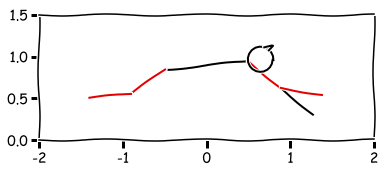

In [393]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-2,2])
    ax.set_ylim([0,1.5])
    
    #plot body
    shoulder_x = 0 + 0.5*m.len[('body','T',1)]*cos(m.q[i,1,'thb'].value)
    shoulder_y = m.q[i,1,'y'].value + 0.5*m.len[('body','T',1)]*sin(m.q[i,1,'thb'].value)  
    hip_x = 0 - 0.5*m.len[('body','T',1)]*cos(m.q[i,1,'thb'].value)
    hip_y = m.q[i,1,'y'].value - 0.5*m.len[('body','T',1)]*sin(m.q[i,1,'thb'].value)
    ax.plot([shoulder_x,hip_x],[shoulder_y,hip_y],color='xkcd:black')
    
    for s in sides:
        if s == 'R':
            col = 'xkcd:black'
        else:
            col = 'xkcd:red'
        # front leg 1
        shoulder_th = m.q[i,1,'thb'].value + m.q[i,1,'thf1%s'%s].value
        elbow_x = shoulder_x + m.len[('legF',s,1)]*sin(shoulder_th)
        elbow_y = shoulder_y - m.len[('legF',s,1)]*cos(shoulder_th)
        ax.plot([shoulder_x,elbow_x],[shoulder_y,elbow_y],color=col)
        
        #front leg 2
        elbow_th = shoulder_th + m.q[i,1,'thf2%s'%s].value
        footf_x = elbow_x + m.len[('legF',s,2)]*sin(elbow_th)
        footf_y = elbow_y - m.len[('legF',s,2)]*cos(elbow_th)
        ax.plot([elbow_x,footf_x],[elbow_y,footf_y],color=col)
        
        # hind leg 1
        hip_th = m.q[i,1,'thb'].value + m.q[i,1,'thh1%s'%s].value
        knee_x = hip_x + m.len[('legH',s,1)]*sin(hip_th)
        knee_y = hip_y - m.len[('legH',s,1)]*cos(hip_th)
        ax.plot([hip_x,knee_x],[hip_y,knee_y],color=col)
        
        # hind leg 2
        knee_th = hip_th + m.q[i,1,'thh2%s'%s].value
        footh_x = knee_x + m.len[('legH',s,2)]*sin(knee_th)
        footh_y = knee_y - m.len[('legH',s,2)]*cos(knee_th)
        ax.plot([knee_x,footh_x],[knee_y,footh_y],color=col)
        
    # head
    r = 0.15*m.len[('body','T',1)]
    cx = shoulder_x + r*np.cos(m.q[i,1,'thb'].value)
    cy = shoulder_y + r*np.sin(m.q[i,1,'thb'].value)
    a = np.linspace(0,2*np.pi,20)
    head_x = cx + r*np.cos(a)
    head_y = cy + r*np.sin(a)
    ax.plot(head_x,head_y,color = 'xkcd:black')
    
    # ear
    ear_x = [cx - r*np.sin(m.q[i,1,'thb'].value - 2*np.pi/8),
            cx - 1.5*r*np.sin(m.q[i,1,'thb'].value - 2*np.pi/8),
            cx - r*np.sin(m.q[i,1,'thb'].value - np.pi/8)]
    ear_y = [cy + r*np.cos(m.q[i,1,'thb'].value - 2*np.pi/8),
            cy + 1.5*r*np.cos(m.q[i,1,'thb'].value - 2*np.pi/8),
            cy + r*np.cos(m.q[i,1,'thb'].value - np.pi/8)]
    ax.plot(ear_x,ear_y,color = 'xkcd:black')
    
plt.xkcd()
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N-1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
